# Neural networks using tensorflow

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import matplotlib.pyplot as plt
import netCDF4 as n
%matplotlib inline
from utils import train_test_split

In [30]:
from tflow_reg import nn_model

#from tflow_reg_new import nn_model

## Import data

In [83]:
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

my_files = {'cloud':cloud, 'relative':relative, 'specific':specific, 'pressure':pressure, 'temperature':temperature}


tcc = cloud.variables["tcc"]
rh = relative.variables["r"]
q = specific.variables["q"]
sp = pressure.variables["sp"]
t2m = temperature.variables["t2m"]

my_vars = {'tcc':tcc, 'rh':rh, 'q':q, 'sp':sp, 't2m':t2m}

n_days = 4
n_grid_boxes = tcc.shape[1]*tcc.shape[2]
X = np.empty((n_grid_boxes*n_days*4, 4))
y = np.empty((n_grid_boxes*n_days*4))



for t in range(int(n_days*4)):
    i = 0
    for key, value in my_vars.items():
        if key == 'tcc':
            y[n_grid_boxes*t:n_grid_boxes*(t+1)] = np.array(value[t, : , :]).flatten()
        elif key == 'rh' or key == 'q':
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, 0, : , :]).flatten()
            i = i+1
        else:
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, : , :]).flatten()
            i=i+1

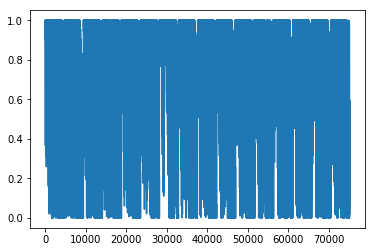

In [84]:

plt.plot(range(y.shape[0]),y,label="Original Data")

### Standarize and split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.2)

Xn_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
yn_train = (y_train - y_train.mean())/y_train.std()

Xn_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
yn_test = (y_test - y_train.mean())/y_train.std()

In [86]:
y.std()

0.3664681174973726

In [87]:
type(Xn_train)

numpy.ndarray

In [88]:
Xn_train.shape

(60122, 4)

## Neural net model

Feed forward neural net with 2 layers. Activation function: Sigmoid for all layers.

TODO: write as function

### Run neural network model

In [89]:
npred = Xn_train.shape[1]
noutput = Xn_train.shape[0]
n_nodes = [npred, 100, 150, 1]

In [90]:
xs = tf.placeholder("float")
ys = tf.placeholder("float")

output = nn_model(xs, n_nodes)
#output = nn_model(xs, Xn_train.shape[1], [50, 50], 1)

### MSE

In [91]:
cost = tf.reduce_mean(tf.square(output-ys))

### R2

In [92]:
total_error = tf.reduce_sum(tf.square(tf.subtract(ys, tf.reduce_mean(ys))))

unexplained_error = tf.reduce_sum(tf.square(tf.subtract(ys, output)))

R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error)) 

### Gradient descent

In [93]:
eta = 0.001
train = tf.train.GradientDescentOptimizer(eta).minimize(cost)

In [94]:
type(Xn_train)

numpy.ndarray

### Plot the data

In [ ]:
with tf.Session() as sess:
    # Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #saver.restore(sess,'yahoo_dataset.ckpt')
    c_t = []
    c_test = []
    r2_t = []
    r2_test = []
    for i in range(100):
        #for j in range(Xn_train.shape[0]):
        #    sess.run([cost,train],feed_dict=    {xs:Xn_train[j,:].reshape(1,npred), ys:yn_train[j]})
        #    # Run cost and train with each sample
        
        sess.run([cost,train],feed_dict=    {xs:Xn_train, ys:yn_train})
        
        c_t.append(sess.run(cost, feed_dict={xs:Xn_train,ys:yn_train}))
        c_test.append(sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'Cost train:',c_t[-1], 'Cost test:',c_test[-1])
        r2_t.append(sess.run(R_squared, feed_dict={xs:Xn_train,ys:yn_train}))
        r2_test.append(sess.run(R_squared, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'R2 train:',r2_t[-1], 'R2 test:',r2_test[-1])
    
    pred = sess.run(output, feed_dict={xs:Xn_test})
    # predict output of test data after training
    print('Cost :',sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
    #y_test = denormalize(df_test,y_test)
    #pred = denormalize(df_test,pred)
    #Denormalize data

    
    
    plt.plot(range(yn_test.shape[0]),yn_test,label="Original Data")
    plt.plot(range(yn_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    plt.ylabel('Total Cloud Cover')
    plt.xlabel('Points')
    #plt.title('Total Cloud Cover')
    plt.savefig('results/data_t0_2layers_10_10_split03.png')
    plt.show()
    
    
    plt.subplot(1,2,1)
    plt.plot(range(len(c_t)), c_t,label="MSE train")
    plt.plot(range(len(c_test)), c_test,label="MSE test")
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    #plt.title('Cost vs. epochs')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(r2_t)), r2_t,label="R2 train")
    plt.plot(range(len(r2_test)), r2_test,label="R2 test")
    plt.legend(loc='best')
    plt.ylabel('R2')
    plt.xlabel('Epochs')
    #plt.title('R2 vs. epochs')
    plt.tight_layout()
    plt.savefig('results/t0_2layers_10_10_split03.png')
    plt.show()
    
  

In [39]:
pred

array([[0.5912345 ],
       [0.5912345 ],
       [0.5912345 ],
       ...,
       [0.5912345 ],
       [0.5912345 ],
       [0.59123445]], dtype=float32)

-2454.9841

In [ ]:
feed_dict={xs:Xn_train[j,:], ys:yn_train[j]}

In [ ]:
Xn_test.shape

In [ ]:
tf.reshape(Xn_train[j,:], [1, npred])

In [ ]:
n_nodes

In [ ]:
output = nn_model(Xn_train, n_nodes)

In [ ]:
output.get_shape().as_list()[1]

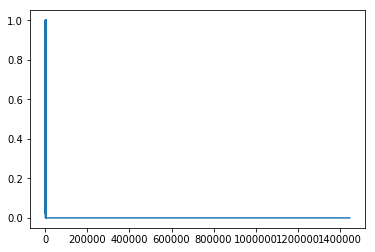

In [20]:
plt.plot(range(y.shape[0]),y,label="Original Data")